module imports

In [21]:
import os
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import re

if os.environ['CONDA_PREFIX'] == '/home/david/.miniforge3/envs/tf-gpu':
    import tensorrt
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '1'

import tensorflow as tf

config

In [22]:
data_dir = '/home/david/spiced_projects/final_project/data/train_val'
input_samplerate = 22050
bsize = 32

plt.style.use('seaborn-v0_8-darkgrid')

file imports

In [23]:
train_ds, val_ds = tf.keras.utils.audio_dataset_from_directory(
    directory=data_dir,
    batch_size=bsize,
    seed=40,
    output_sequence_length=input_samplerate,
    validation_split=0.2,
    subset='both'
)

Found 800 files belonging to 8 classes.
Using 640 files for training.
Using 160 files for validation.


In [24]:
label_names = train_ds.class_names
print("label names:", label_names)

label names: ['close', 'exit', 'files', 'mail', 'media', 'open', 'silence', 'web']


export `label_names` to config.py

In [25]:
config_file = open("/home/david/spiced_projects/final_project/code/config.py", "r")
config_content = config_file.read()
config_file.close()

config_content_updated = re.sub("label_names.*]", f"label_names = {label_names}", config_content)

config_file = open("/home/david/spiced_projects/final_project/code/config.py", "w")
config_file.write(config_content_updated)
config_file.close()

utility functions

In [26]:
def make_squeezed_ds(ds):
    return ds.map(
        lambda wave, label: (tf.squeeze(wave, axis=-1), label),
        num_parallel_calls=tf.data.AUTOTUNE
    )

def get_spectrogram(wave):
    spec = tf.signal.stft(wave, frame_length=300, frame_step=85)
    spec = tf.abs(spec)
    spec = spec[..., tf.newaxis]
    return spec


def make_spec_ds(ds):
    return ds.map(
        lambda wave, label: (get_spectrogram(wave), label),
        num_parallel_calls=tf.data.AUTOTUNE
    )

In [27]:
train_spec_ds = make_spec_ds(make_squeezed_ds(train_ds))
val_spec_ds = make_spec_ds(make_squeezed_ds(val_ds))

In [28]:
# extract example spectrograms for input shape
for example_spec_batch, _ in train_spec_ds.take(1):
  break

final shape check:

In [29]:
example_spec_batch.shape
# expected: TensorShape([bsize, spec_rows, spec_cols, n_channels])

TensorShape([32, 256, 257, 1])

In [30]:
# for fitting speed increase
train_spec_ds = train_spec_ds.cache().shuffle(10000, reshuffle_each_iteration=False).prefetch(tf.data.AUTOTUNE)
val_spec_ds = val_spec_ds.cache().prefetch(tf.data.AUTOTUNE)

model architecture

In [31]:
input_shape = example_spec_batch.shape[1:]
last_layer_neurons = len(label_names)

# create normalization layer and fit its parameters to the training dataset
normalization_layer = tf.keras.layers.Normalization()
normalization_layer.adapt(data=train_spec_ds.map(lambda spec, label: spec))

model = tf.keras.models.Sequential([
    
    tf.keras.layers.Input(shape=input_shape),
    tf.keras.layers.Resizing(32, 32, interpolation='gaussian'),
    normalization_layer,
    
    tf.keras.layers.Conv2D(16, 3, activation='selu'),
    tf.keras.layers.MaxPooling2D(),
    tf.keras.layers.Conv2D(32, 3, activation='selu'),
    tf.keras.layers.MaxPooling2D(),
    tf.keras.layers.Conv2D(64, 3, activation='selu'),
    tf.keras.layers.MaxPooling2D(),

    tf.keras.layers.Flatten(),
    
    tf.keras.layers.Dense(64, 'selu'),
    
    tf.keras.layers.Dense(last_layer_neurons),
])

In [32]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 resizing_1 (Resizing)       (None, 32, 32, 1)         0         
                                                                 
 normalization_1 (Normaliza  (None, 32, 32, 1)         3         
 tion)                                                           
                                                                 
 conv2d_3 (Conv2D)           (None, 30, 30, 16)        160       
                                                                 
 max_pooling2d_3 (MaxPoolin  (None, 15, 15, 16)        0         
 g2D)                                                            
                                                                 
 conv2d_4 (Conv2D)           (None, 13, 13, 32)        4640      
                                                                 
 max_pooling2d_4 (MaxPoolin  (None, 6, 6, 32)         

In [33]:
model.compile(
    optimizer=tf.keras.optimizers.Adam(),
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    metrics=['accuracy'],
)

model training

In [53]:
history = model.fit(
    train_spec_ds,
    validation_data=val_spec_ds,
    epochs=100,
)

Epoch 1/100
20/20 [==============================] - 0s 5ms/step - loss: 2.3060e-07 - accuracy: 1.0000 - val_loss: 2.5468e-04 - val_accuracy: 1.0000
Epoch 2/100
20/20 [==============================] - 0s 5ms/step - loss: 2.2817e-07 - accuracy: 1.0000 - val_loss: 2.5352e-04 - val_accuracy: 1.0000
Epoch 3/100
20/20 [==============================] - 0s 5ms/step - loss: 2.2463e-07 - accuracy: 1.0000 - val_loss: 2.5214e-04 - val_accuracy: 1.0000
Epoch 4/100
20/20 [==============================] - 0s 5ms/step - loss: 2.2184e-07 - accuracy: 1.0000 - val_loss: 2.5132e-04 - val_accuracy: 1.0000
Epoch 5/100
20/20 [==============================] - 0s 5ms/step - loss: 2.1998e-07 - accuracy: 1.0000 - val_loss: 2.5054e-04 - val_accuracy: 1.0000
Epoch 6/100
20/20 [==============================] - 0s 5ms/step - loss: 2.1793e-07 - accuracy: 1.0000 - val_loss: 2.4979e-04 - val_accuracy: 1.0000
Epoch 7/100
20/20 [==============================] - 0s 5ms/step - loss: 2.1588e-07 - accuracy: 1.0000 - v

In [35]:
%%script echo saving skipped

model.save("/home/david/spiced_projects/final_project/models/voice_command_model_small_v2.h5", save_format='h5', overwrite=False)
print("Model saved!")

saving skipped


model evaluation

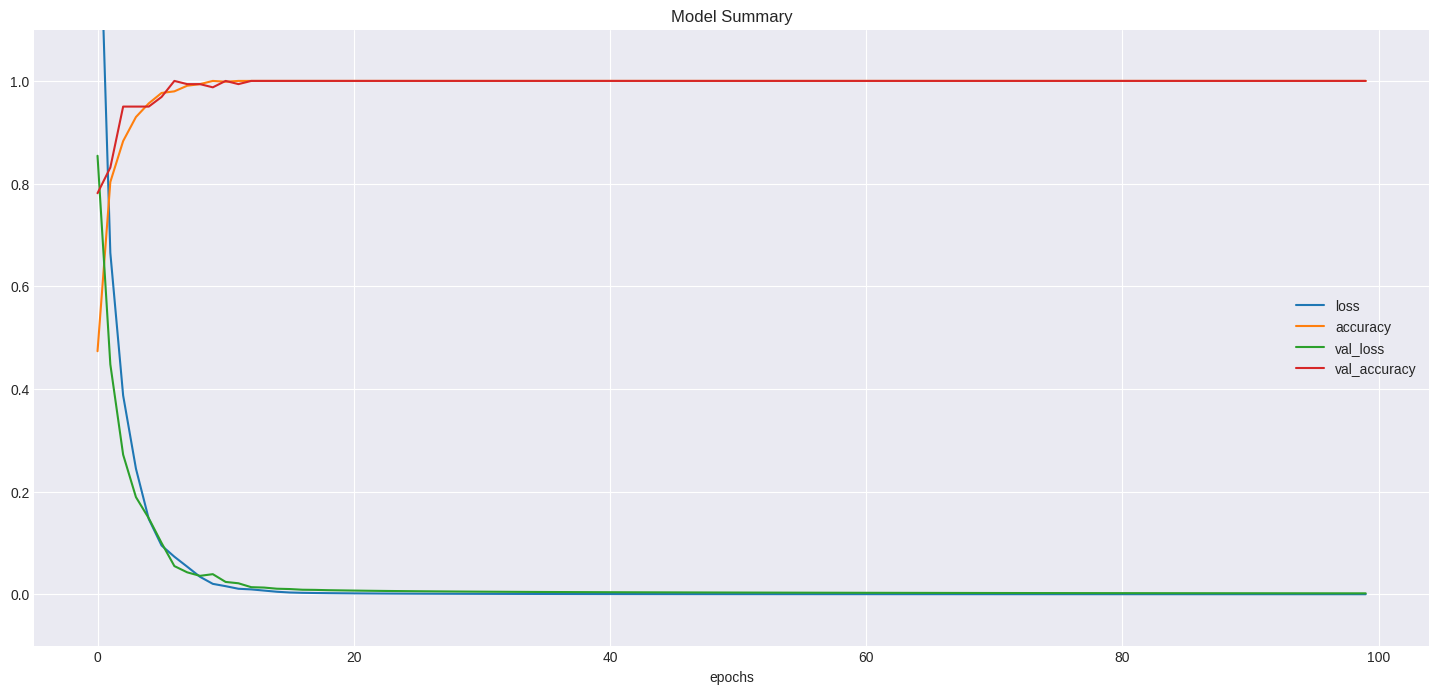

In [36]:
r = 4/9
s = 18
pd.DataFrame(history.history).plot(figsize=(s,s*r))
plt.ylim([-0.1,1.1])
plt.title("Model Summary")
plt.xlabel("epochs");

In [37]:
test_ds = tf.keras.utils.audio_dataset_from_directory(
    directory='/home/david/spiced_projects/final_project/data/test',
    output_sequence_length=input_samplerate,
    batch_size=5,
    shuffle=False
)

Found 80 files belonging to 8 classes.


In [38]:
test_squeezed_ds = make_squeezed_ds(test_ds)
test_spec_ds = make_spec_ds(test_squeezed_ds)
test_spec_ds = test_spec_ds.cache().prefetch(tf.data.AUTOTUNE)

In [54]:
y_pred = tf.argmax(tf.nn.softmax(model.predict(test_spec_ds)), axis=1)
y_true = tf.concat(list(test_spec_ds.map(lambda _, label: label)), axis=0)

 1/16 [>.............................] - ETA: 0s

16/16 [==============================] - 0s 2ms/step


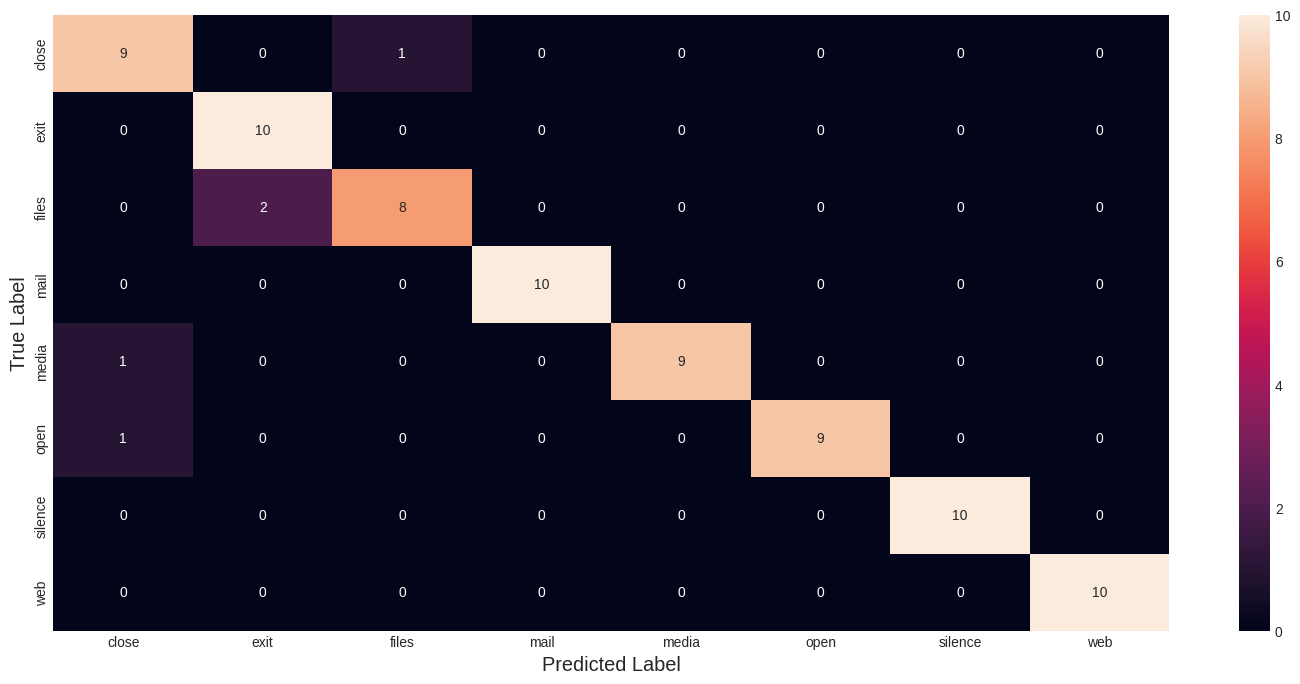

In [55]:
cmx = tf.math.confusion_matrix(y_true, y_pred)
plt.figure(figsize=(18, 18*(4/9)))
sns.heatmap(cmx,
            xticklabels=label_names,
            yticklabels=label_names,
            annot=True,
            fmt='g'
            )
plt.xlabel('Predicted Label', {"fontsize": "x-large"})
plt.ylabel('True Label', {"fontsize": "x-large"})
plt.show()